# Problem Statement

1. Who is not eligible for benefit? (outlier)
2. How much we should pay for eligible families?

In [1]:
from models import AnomalyDetection
from helper_functions import Tools
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Dataset Description
-


# Load The Dataset

In [2]:
def read_files():
    folder = sorted(glob.glob("./data/*.csv"))
    dfs = [pd.read_csv(f, sep=",", header=0) for f in folder]

    drop = {'drop_application': ['START_TIME', 'END_TIME','STREET_NAME', 'BIRTH_DATE', 'FIRST_NAME', 'LAST_NAME', 'EMAIL', 'HOME_AREA_CODE', 'PHONE_NUMBER', 'EMPLOYMENT_STATUS'],
            'drop_dependent': ['P8N', 'PARTNER_P8N']}
    dfs[0] = dfs[0].drop(drop['drop_application'], axis=1)
    dfs[2] = dfs[2].drop(drop['drop_dependent'], axis=1)

    # don't need to merge server-log-data and spouse-common-law-data
    df = dfs[0].merge(dfs[1], on='APP_ID').merge(dfs[2], on='APP_ID').merge(dfs[3], on='APP_ID')

    return df

In [3]:
file = read_files()

In [4]:
print(file.shape)
file

(186958, 21)


,APP_ID,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,TRANSIT_NUMBER,ACCOUNT_NUMBER,...,DATE_BIRTH_2,DATE_BIRTH_3,DATE_BIRTH_4,DATE_BIRTH_5,DATE_BIRTH_6,DATE_BIRTH_7,DATE_BIRTH_8,DATE_BIRTH_9,employment_income_1,employment_income_2
0,100000,39916021.0,65771788.0,COURTICE,L1E0J2,6.0,800,925,6.709730e+11,14620.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1176.136251,416.158132
1,100001,28596991.0,25829667.0,SURREY,V3W9W5,10.0,1500,284,7.343455e+11,93305.0,...,2022-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21058.120853,13290.879147
2,100002,65751811.0,63839036.0,VANCOUVER,V5Z1Y2,10.0,1500,248,1.454532e+11,64103.0,...,2013-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7423.732510,986.966806
3,100003,43012353.0,73277757.0,MARKHAM,L3R8A5,6.0,800,499,7.194849e+11,65314.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31129.608140,0.000000
4,100004,34120896.0,72359770.0,RICHMOND,V7A3Y7,10.0,800,248,2.990500e+11,20629.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12181.918095,1363.765599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186953,286953,39587551.0,78857785.0,MONTREAL,H1V1A6,5.0,0,121,9.644518e+11,27516.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6327.232148,14833.136305
186954,286954,46553423.0,68775805.0,FARNHAM,J2N2N1,5.0,0,456,1.353163e+11,91902.0,...,2016-10-14,2013-07-25,NaN,NaN,NaN,NaN,NaN,NaN,13080.087279,2525.774133
186955,286955,29927474.0,NaN,QUEBEC,G2B2E4,5.0,0,683,4.946306e+11,57894.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50968.204560,0.000000
186956,286956,64268904.0,28350988.0,SCARBOROUGH,M1J3P5,6.0,0,248,5.059813e+11,31755.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,478.636732,213.383420


# Data Cleaning

### *Missing Values*

In [5]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186958 entries, 0 to 186957
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   APP_ID                        186958 non-null  int64  
 1   P8N                           186921 non-null  float64
 2   PARTNER_P8N                   158996 non-null  float64
 3   MUNICIPALITY_NAME             186958 non-null  object 
 4   POSTAL_CODE                   186844 non-null  object 
 5   PROVINCE__ID                  186844 non-null  float64
 6   CUMUL_PAY                     186958 non-null  int64  
 7   FINANCIAL_INSTITUTION_NUMBER  186958 non-null  int64  
 8   TRANSIT_NUMBER                186958 non-null  float64
 9   ACCOUNT_NUMBER                186958 non-null  float64
 10  DATE_BIRTH_1                  186958 non-null  object 
 11  DATE_BIRTH_2                  38830 non-null   object 
 12  DATE_BIRTH_3                  8206 non-null 

In [6]:
# check for null
file.isnull().sum()

APP_ID                               0
P8N                                 37
PARTNER_P8N                      27962
MUNICIPALITY_NAME                    0
POSTAL_CODE                        114
PROVINCE__ID                       114
CUMUL_PAY                            0
FINANCIAL_INSTITUTION_NUMBER         0
TRANSIT_NUMBER                       0
ACCOUNT_NUMBER                       0
DATE_BIRTH_1                         0
DATE_BIRTH_2                    148128
DATE_BIRTH_3                    178752
DATE_BIRTH_4                    184491
DATE_BIRTH_5                    186435
DATE_BIRTH_6                    186955
DATE_BIRTH_7                    186958
DATE_BIRTH_8                    186958
DATE_BIRTH_9                    186958
employment_income_1                  0
employment_income_2                  0
dtype: int64

In [7]:
# draft: make all null = 0
for i in file.columns:
    if file[i].isnull().sum() > 0:
        file[i] = file[i].fillna(0)

### *Update Values*

In [8]:
for i in range(1,10):
    name = "DATE_BIRTH_" + str(i)
    if file[name].dtypes == object:
        file[name] = 2023 - file[name].str.split('-').str[0].fillna(0).astype("int")
        file[name].loc[(file[name] <= 0) | (file[name] >= 100)] = 0

# Data Preprocessing

### *Eligibility*

In [9]:
tag = ["VALID_INCOME", "VALID_P8N", "VALID_ADDRESS", "VALID_BANK_ACC", "VALID_KIDS"]
for i in tag:
    file[i] = 0

for i in range(len(file)):
    total = file.employment_income_1[i] + file.employment_income_2[i]
    if total <= 70000:
        file.VALID_INCOME[i] = 1
    if 0 < file.P8N[i] <= 99999999:
        file.VALID_P8N[i] = 1
    if 1 <= file.PROVINCE__ID[i] <= 13:
        file.VALID_ADDRESS[i] = 1
    if 0 < file.FINANCIAL_INSTITUTION_NUMBER[i] <= 999 and 0 < file.TRANSIT_NUMBER[i] <= 99999:
        file.VALID_BANK_ACC[i] = 1
    if 0 < file.DATE_BIRTH_1[i] <= 18 or 0 < file.DATE_BIRTH_2[i] <= 18 or 0 < file.DATE_BIRTH_3[i] <= 18 or 0 < file.DATE_BIRTH_4[i] <= 18 or 0 < file.DATE_BIRTH_5[i] <= 18 or 0 < file.DATE_BIRTH_6[i] <= 18 or 0 < file.DATE_BIRTH_7[i] <= 18 or 0 < file.DATE_BIRTH_8[i] <= 18 or 0 < file.DATE_BIRTH_9[i] <= 18:
        file.VALID_KIDS[i] = 1

In [10]:
data = file.loc[(file.VALID_INCOME == 1) & (file.VALID_P8N == 1) & (file.VALID_ADDRESS == 1) & (file.VALID_BANK_ACC == 1) & (file.VALID_KIDS == 1)]
data

,APP_ID,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,TRANSIT_NUMBER,ACCOUNT_NUMBER,...,DATE_BIRTH_7,DATE_BIRTH_8,DATE_BIRTH_9,employment_income_1,employment_income_2,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS
46926,146926,16595392.0,20671593.0,MONTREAL,H2E2R9,5.0,800,248,12345.0,12345678.0,...,0.0,0.0,0.0,7493.568661,2519.909341,1,1,1,1,1
47074,147074,32778545.0,89827787.0,MONCTON,E1G4Z5,3.0,400,913,98867.0,98867.0,...,0.0,0.0,0.0,44198.507024,21051.639975,1,1,1,1,1
47577,147577,26423493.0,0.0,LASALLE,H8R3N6,5.0,500,925,12345.0,12345678.0,...,0.0,0.0,0.0,28802.192085,0.000000,1,1,1,1,1
47815,147815,26504422.0,32892918.0,THUNDER BAY,P7C5A9,6.0,250,456,11111.0,123123123.0,...,0.0,0.0,0.0,54521.934197,14969.907796,1,1,1,1,1
48015,148015,69248936.0,33697651.0,LACHUTE,J8H1Z7,5.0,600,925,12345.0,12345678.0,...,0.0,0.0,0.0,30573.117498,37401.073417,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183646,283646,60514406.0,54457806.0,THOROLD,L2V3N8,6.0,0,936,80360.0,80360.0,...,0.0,0.0,0.0,9596.453454,2827.535849,1,1,1,1,1
183731,283731,70781854.0,85703364.0,MONTREAL,H4E3J2,5.0,0,432,77249.0,77249.0,...,0.0,0.0,0.0,33465.356773,10040.994743,1,1,1,1,1
185582,285582,38872330.0,23903584.0,QUEBEC,G1K3R4,5.0,0,248,61903.0,61903.0,...,0.0,0.0,0.0,41215.175425,9845.474576,1,1,1,1,1
185762,285762,69229687.0,12910174.0,TIMMINS,P4R1C7,6.0,0,456,36829.0,36829.0,...,0.0,0.0,0.0,21671.914937,39316.824119,1,1,1,1,1


### *Numericalize*

In [11]:
data_num, data_num_key = Tools.numericalize(data)

### *Normalize*

In [16]:
data_nor = Tools.normalization(data_num, "min-max")
data_nor.columns = data_num.columns.to_list()
data_nor["APP_ID"] = data_num.APP_ID.reset_index(drop=True)
data_nor.set_index("APP_ID", inplace=True)

### *PCA*

In [19]:
data_pca = Tools.pca(1, data_nor.drop("CUMUL_PAY", axis=1))
data_pca["pay"] = data_nor["CUMUL_PAY"].reset_index(drop=True)

In [20]:
data_pca

,0,pay
0,-0.253617,0.421053
1,-0.869811,0.210526
2,-0.206088,0.263158
3,0.406851,0.131579
4,-0.241060,0.315789
...,...,...
278,-0.252345,0.000000
279,-0.451805,0.000000
280,-0.507612,0.000000
281,0.160255,0.000000


<AxesSubplot:xlabel='pay', ylabel='0'>

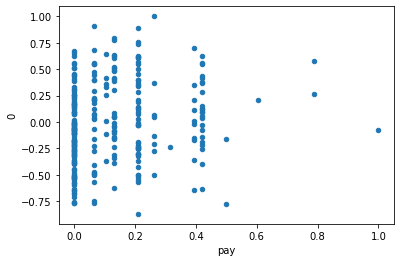

In [23]:
data_pca.plot(x='pay', y=0, kind='scatter')

In [24]:
data_pca = Tools.pca(2, data_nor)

In [25]:
data_pca

,0,1
0,-0.221683,-0.257271
1,-0.877707,0.549296
2,-0.204674,0.302794
3,0.402224,0.065792
4,-0.221773,0.089039
...,...,...
278,-0.274974,0.555476
279,-0.464133,0.051248
280,-0.523952,0.065743
281,0.140235,0.146870


<AxesSubplot:xlabel='0', ylabel='1'>

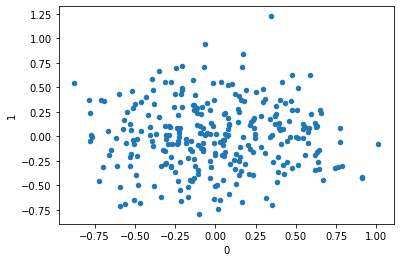

In [26]:
data_pca.plot(x=0, y=1, kind='scatter')

# Data Visualization

### *Columns Distribution*

In [29]:
# basic description
data_num.describe()

,APP_ID,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,TRANSIT_NUMBER,ACCOUNT_NUMBER,...,DATE_BIRTH_7,DATE_BIRTH_8,DATE_BIRTH_9,employment_income_1,employment_income_2,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS
count,283.000000,2.830000e+02,2.830000e+02,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,2.830000e+02,...,283.0,283.0,283.0,283.000000,283.000000,283.0,283.0,283.0,283.0,283.0
mean,210831.650177,5.103105e+07,4.163587e+07,81.056537,141.000000,6.328622,252.296820,453.706714,33947.982332,1.139757e+07,...,0.0,0.0,0.0,23738.698898,10252.105277,1.0,1.0,1.0,1.0,1.0
std,45164.511365,2.413355e+07,2.754115e+07,47.502784,81.839273,2.225288,306.698312,263.420293,31114.887013,3.048578e+07,...,0.0,0.0,0.0,19458.409398,12481.656229,0.0,0.0,0.0,0.0,0.0
min,146926.000000,1.037748e+07,0.000000e+00,0.000000,0.000000,1.000000,0.000000,121.000000,12.000000,1.800000e+02,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
25%,169624.000000,2.939764e+07,2.227701e+07,37.500000,70.500000,5.000000,0.000000,248.000000,12345.000000,3.863800e+04,...,0.0,0.0,0.0,7036.144842,569.563066,1.0,1.0,1.0,1.0,1.0
50%,203506.000000,5.021005e+07,3.996253e+07,83.000000,141.000000,6.000000,125.000000,432.000000,15079.000000,7.277000e+04,...,0.0,0.0,0.0,20740.960260,5820.519003,1.0,1.0,1.0,1.0,1.0
75%,255590.500000,7.256254e+07,6.561586e+07,124.000000,211.500000,8.000000,400.000000,683.000000,57894.000000,1.234568e+07,...,0.0,0.0,0.0,36876.723413,14508.835232,1.0,1.0,1.0,1.0,1.0
max,286207.000000,8.965461e+07,8.982779e+07,159.000000,282.000000,10.000000,1900.000000,936.000000,99925.000000,1.231231e+08,...,0.0,0.0,0.0,69691.263423,67811.918450,1.0,1.0,1.0,1.0,1.0


In [30]:
# other methods will check the time-based data; thus, we will skip this step
Tools.graph_frequency_numeric(data_num.iloc[:, :-2])

AttributeError: module 'iSchool_Hackathon.tools' has no attribute 'graph_frequency_numeric'

### *Correlation Detection*

In [31]:
data_nor.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,TRANSIT_NUMBER,ACCOUNT_NUMBER,DATE_BIRTH_1,DATE_BIRTH_2,DATE_BIRTH_3,DATE_BIRTH_4,DATE_BIRTH_5,DATE_BIRTH_6,DATE_BIRTH_7,DATE_BIRTH_8,DATE_BIRTH_9,employment_income_1,employment_income_2,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS
P8N,1.00,0.03,0.01,0.05,0.02,0.11,-0.04,-0.02,0.11,0.05,-0.07,0.00,0.08,nan,nan,nan,nan,nan,-0.09,0.02,nan,nan,nan,nan,nan
PARTNER_P8N,0.03,1.00,-0.07,-0.06,-0.04,0.07,0.04,0.03,-0.01,-0.01,-0.01,0.02,-0.03,nan,nan,nan,nan,nan,-0.18,0.19,nan,nan,nan,nan,nan
MUNICIPALITY_NAME,0.01,-0.07,1.00,0.02,-0.02,-0.06,0.02,0.00,-0.02,-0.04,-0.06,-0.14,-0.02,nan,nan,nan,nan,nan,0.03,-0.08,nan,nan,nan,nan,nan
POSTAL_CODE,0.05,-0.06,0.02,1.00,0.93,0.09,0.02,-0.09,0.17,-0.05,-0.08,-0.07,-0.09,nan,nan,nan,nan,nan,0.03,-0.04,nan,nan,nan,nan,nan
PROVINCE__ID,0.02,-0.04,-0.02,0.93,1.00,0.07,0.01,-0.06,0.14,-0.06,-0.08,-0.06,-0.05,nan,nan,nan,nan,nan,0.00,-0.03,nan,nan,nan,nan,nan
CUMUL_PAY,0.11,0.07,-0.06,0.09,0.07,1.00,-0.09,-0.25,0.27,-0.02,0.15,0.13,0.00,nan,nan,nan,nan,nan,-0.31,-0.19,nan,nan,nan,nan,nan
FINANCIAL_INSTITUTION_NUMBER,-0.04,0.04,0.02,0.02,0.01,-0.09,1.00,0.09,0.03,-0.04,-0.05,0.02,0.06,nan,nan,nan,nan,nan,0.01,0.01,nan,nan,nan,nan,nan
TRANSIT_NUMBER,-0.02,0.03,0.00,-0.09,-0.06,-0.25,0.09,1.00,-0.27,-0.00,0.05,0.03,0.05,nan,nan,nan,nan,nan,0.02,0.05,nan,nan,nan,nan,nan
ACCOUNT_NUMBER,0.11,-0.01,-0.02,0.17,0.14,0.27,0.03,-0.27,1.00,0.03,-0.04,-0.07,-0.03,nan,nan,nan,nan,nan,-0.01,-0.11,nan,nan,nan,nan,nan
DATE_BIRTH_1,0.05,-0.01,-0.04,-0.05,-0.06,-0.02,-0.04,-0.00,0.03,1.00,0.13,0.09,-0.05,nan,nan,nan,nan,nan,0.03,-0.10,nan,nan,nan,nan,nan
